# Models and Evaluation

In [11]:
import pandas as pd
import numpy as np

data = pd.read_csv('data_processed/data.csv')

data.drop('loan_id', axis=1, inplace=True)

features = data.drop('status', axis=1).values
target = data['status'].values
print(data)
print(target)

     account_id  amount  duration  payments  status  client_id  district_id  \
0          1787   96396        12      8033      -1       2166           30   
1          1801  165960        36      4610       1       2181           46   
2          9188  127080        60      2118       1      11314           45   
3          1843  105804        36      2939       1       2235           14   
4         11013  274740        60      4579       1      13539           63   
..          ...     ...       ...       ...     ...        ...          ...   
323        9030  155616        48      3242       1      11121           72   
324        3189  222180        60      3703      -1       3855           29   
325        8972   45024        48       938       1      11050           70   
326       10963  115812        36      3217       1      13480           16   
327       11362  129408        24      5392       1      13971           67   

     gender  disp_id  has_disponent  age_on_loan_re

In [12]:
def recall(cm, i):
    return cm[i][i]/sum(cm[i])

def precision(cm, i):
    cmt = np.copy(cm).transpose()
    return cmt[i][i]/sum(cmt[i])

def f_measure(cm, i):
    p = precision(cm, i)*100
    r = recall(cm, i)*100
    return 2 * (p * r) / (p + r)

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def conf_matrix(testing_classes, predicted_classes):
    cm =  confusion_matrix(testing_classes, predicted_classes)
    '''
    print("TP:", cm[1][1])
    print("TN:", cm[0][0])
    print("FP:", cm[0][1])
    print("FN:", cm[1][0])
    '''
    ConfusionMatrixDisplay(cm, display_labels=[-1, 1]).plot()

In [14]:
from sklearn.model_selection import train_test_split

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(features, target, test_size=0.25, random_state=1)

In [15]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(training_inputs, training_classes)

DecisionTreeClassifier()

In [16]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(training_inputs, training_classes)

RandomForestClassifier()

In [17]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(training_inputs, training_classes)

SVC()

In [18]:
print("DTC:", dtc.score(testing_inputs, testing_classes))
print("RF :", rf.score(testing_inputs, testing_classes))
print("SVC:", svc.score(testing_inputs, testing_classes))

DTC: 0.7439024390243902
RF : 0.8658536585365854
SVC: 0.8780487804878049


In [19]:
dtc_pred = dtc.predict(testing_inputs)
rf_pred = rf.predict(testing_inputs)
svc_pred = svc.predict(testing_inputs)

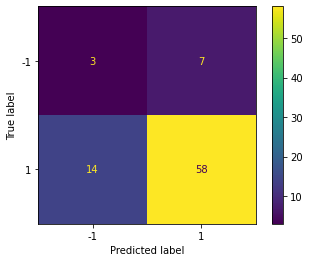

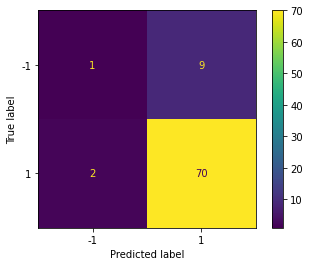

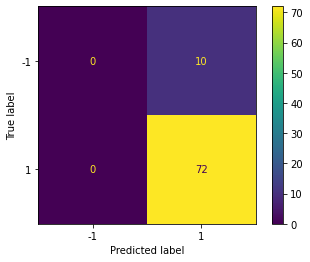

In [20]:
conf_matrix(testing_classes, dtc_pred)
conf_matrix(testing_classes, rf_pred)
conf_matrix(testing_classes, svc_pred)